In [1]:
# install required packages
%pip install pydicom matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.3 MB/s eta 0:00:00a 0:00:01
  Using cached matplotlib-3.7.1-cp39-cp39-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached Pillow-9.5.0-cp39-cp39-macosx_10_10_x86_64.whl (3.4 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_10_9_x86_64.whl (65 kB)
  Using cached contourpy-1.0.7-cp39-cp39-macosx_10_9_x86_64.whl (244 kB)
  Using cached numpy-1.24.3-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
# import required packages
import pydicom # pydicom is a package for working with DICOM files such as medical images, reports, and radiotherapy objects
import os # os module provides functions for interacting with the operating system
import matplotlib.pyplot as plt # matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
import numpy as np # NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

In [ ]:
dicom_dir = "dataset/manifest-MjbMt99Q1553106146386120388/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623/11.000000-AXIAL SE T1 - RESEARCH-12555/"
rtstruct = "dataset/manifest-MjbMt99Q1553106146386120388/Soft-tissue-Sarcoma/STS_001/09-03-2000-NA-THIGH-48623/1.000000-RTstructT1-64320/1-1.dcm"

In [15]:
# Load a single DICOM file
dcm = pydicom.dcmread(dicom_dir + "1-01.dcm")
# Print some attributes
print(dcm.PatientID)
print(dcm.Modality)


STS_001
MR


In [6]:
def get_image_position(dcm): # get the image position of the DICOM file
    return np.array(dcm.ImagePositionPatient)

def get_pixel_spacing(dcm): # get the pixel spacing of the DICOM file
    return np.array(dcm.PixelSpacing)

def convert_to_pixel_coordinates(contour_data, image_position, pixel_spacing): # convert the contour data to pixel coordinates
    contour_points = np.array(contour_data).reshape(-1, 3)
    return np.round((contour_points[:, :2] - image_position[:2]) / pixel_spacing[:2]).astype(int)

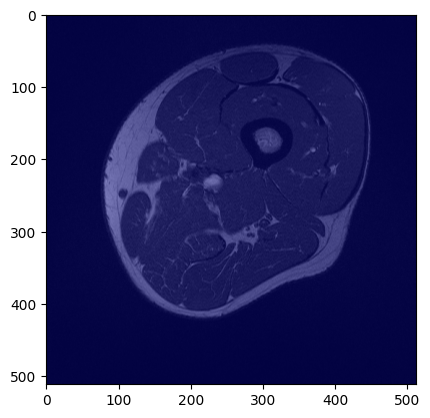

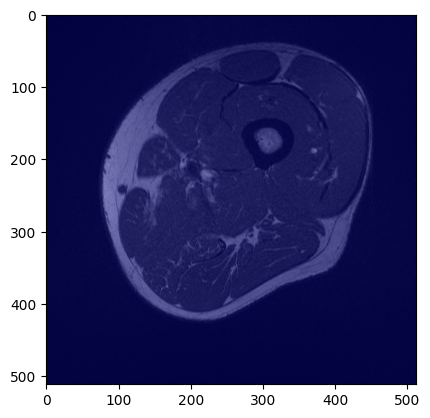

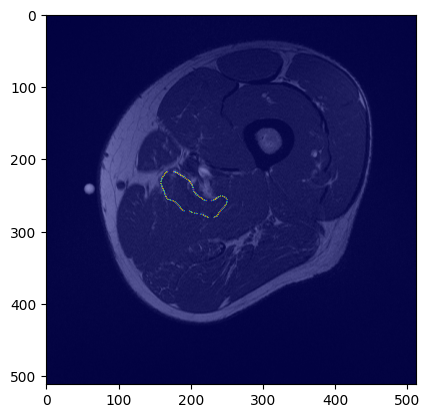

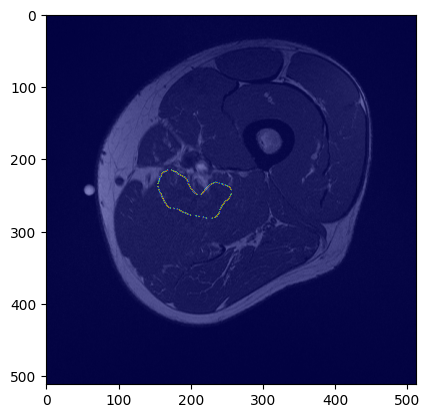

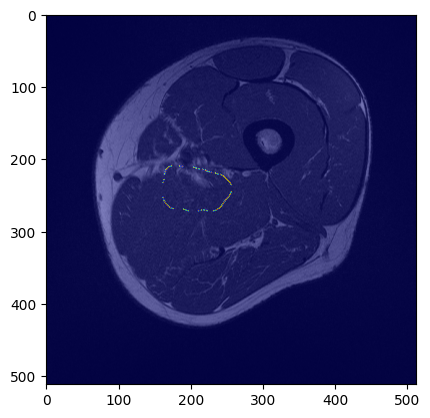

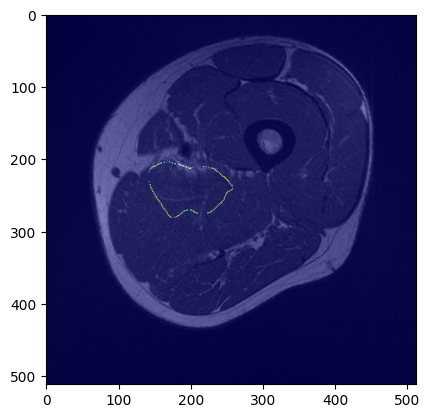

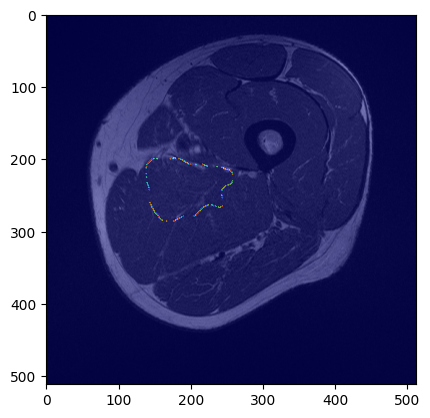

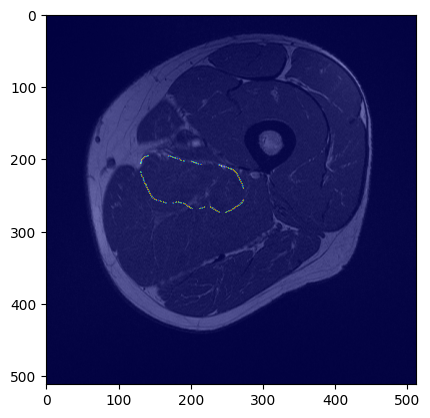

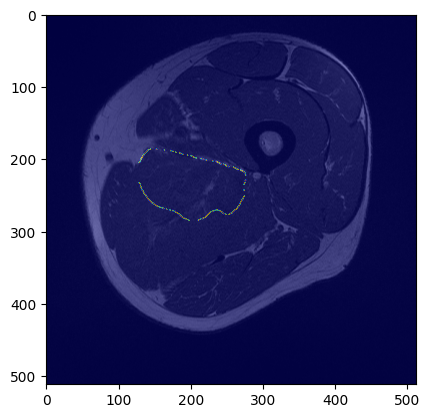

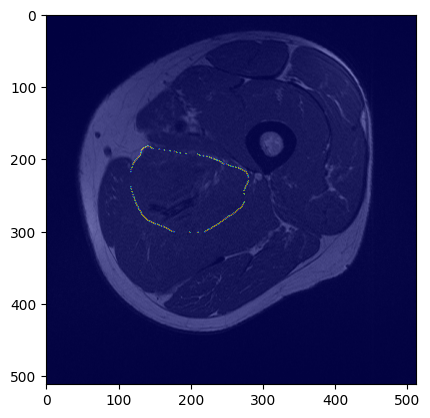

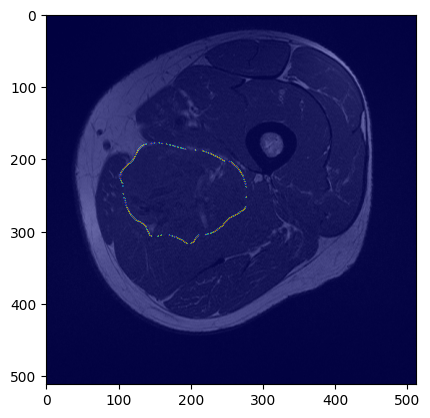

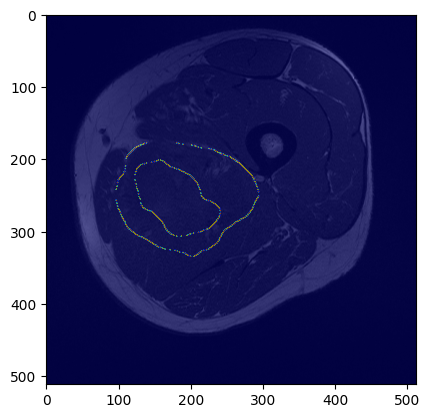

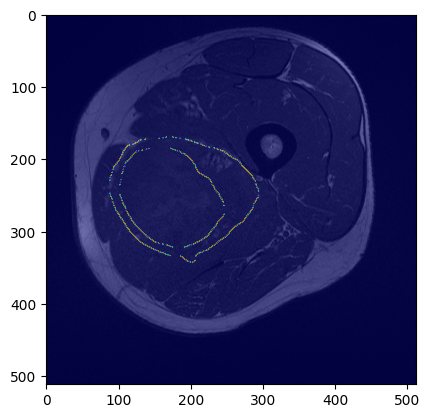

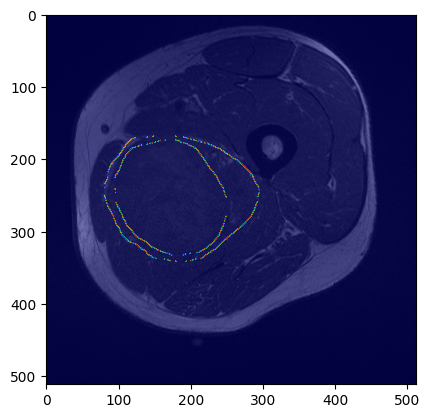

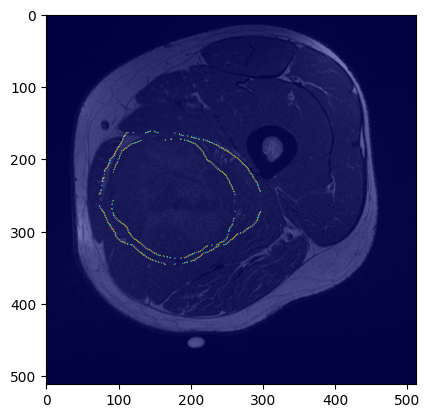

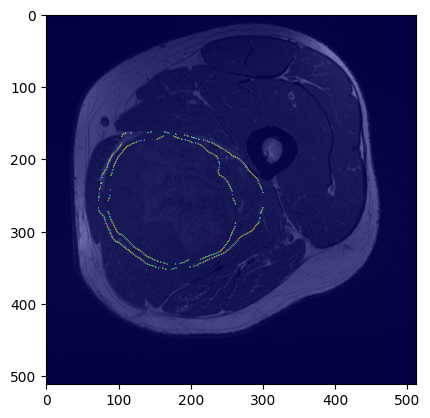

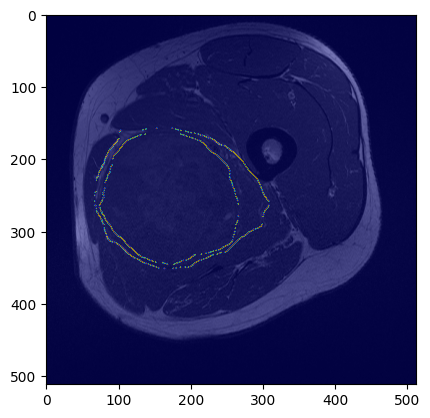

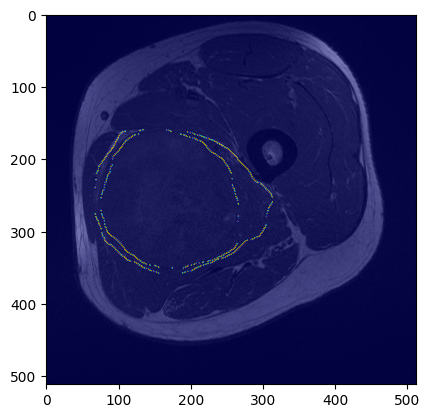

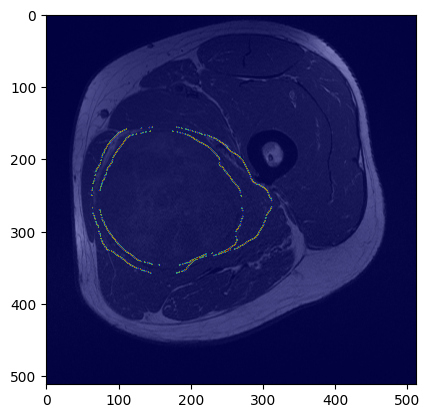

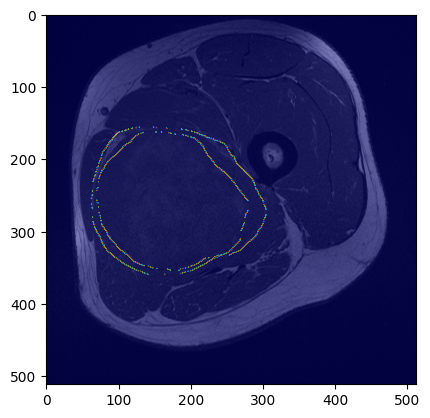

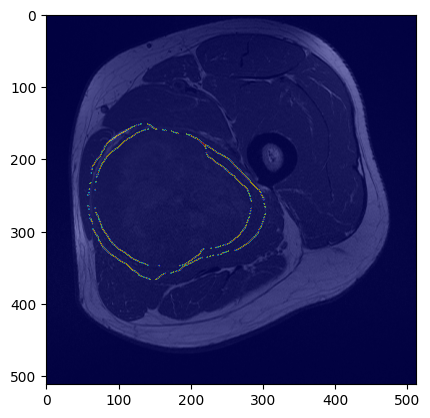

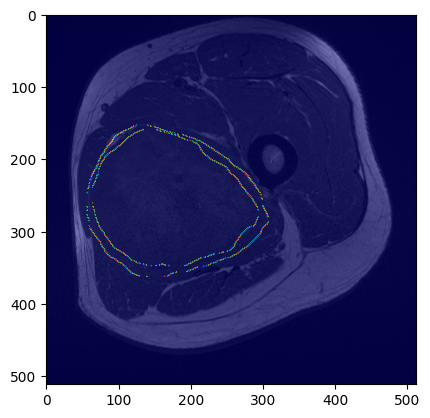

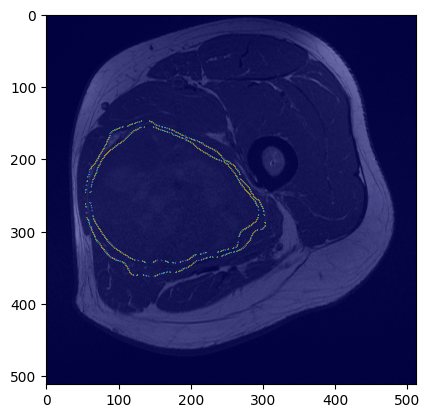

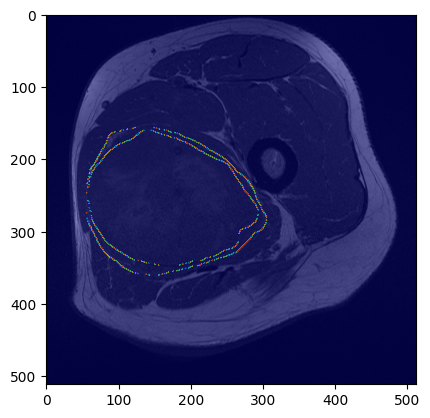

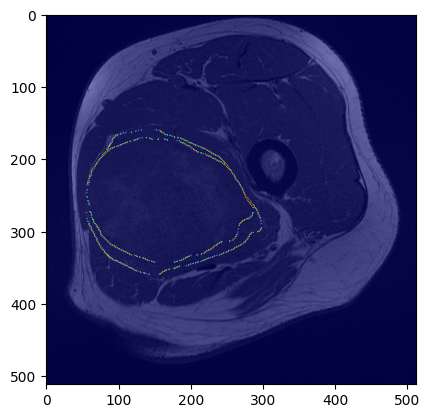

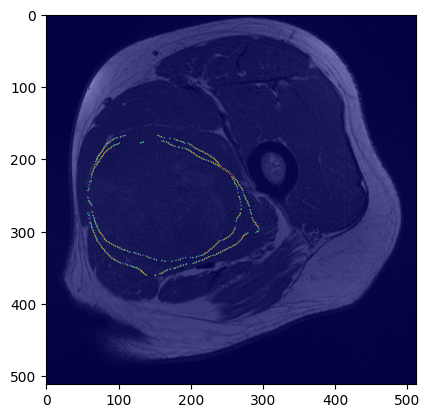

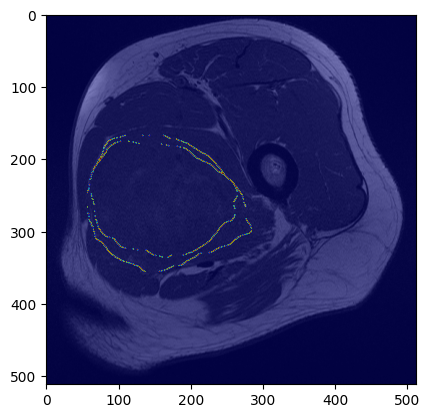

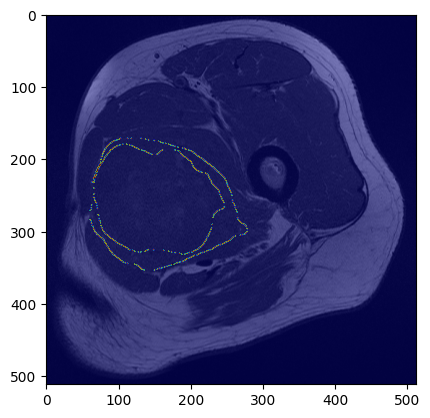

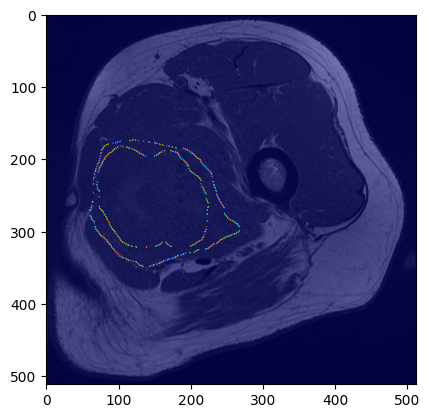

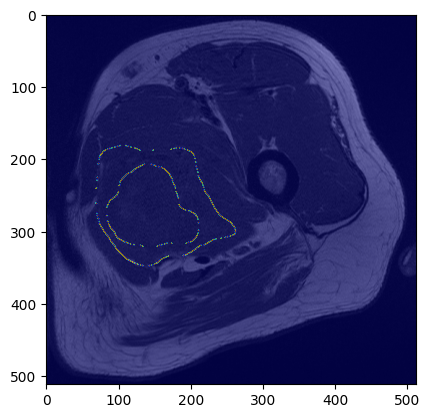

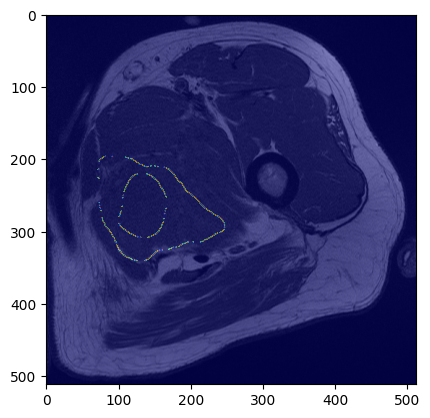

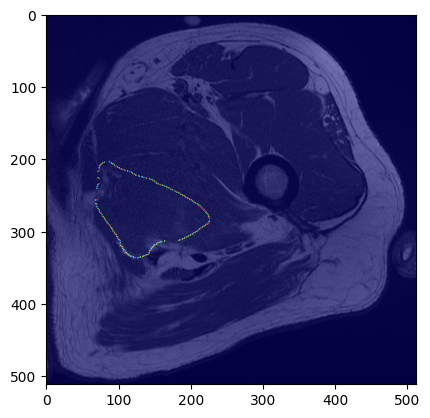

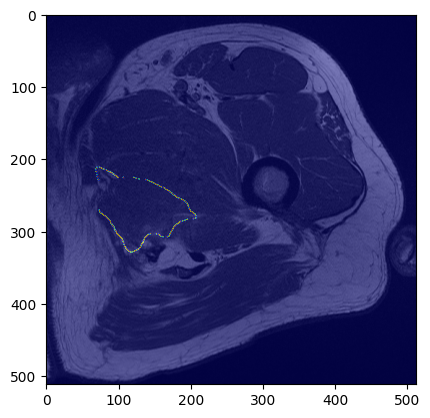

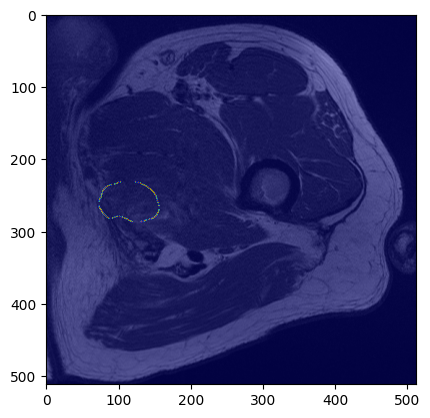

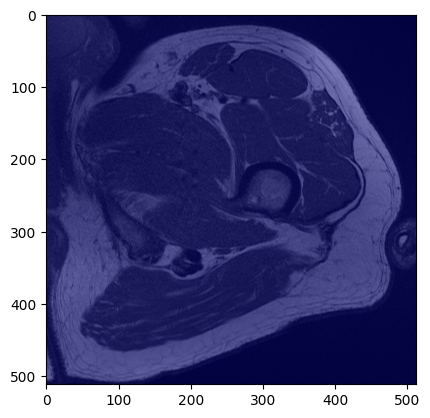

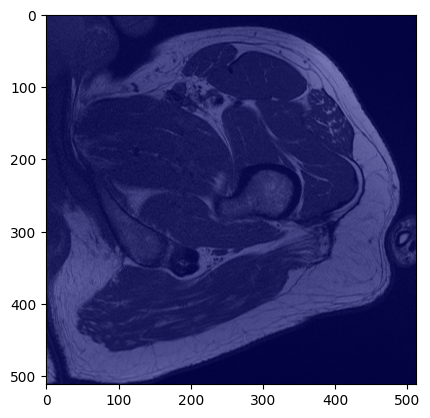

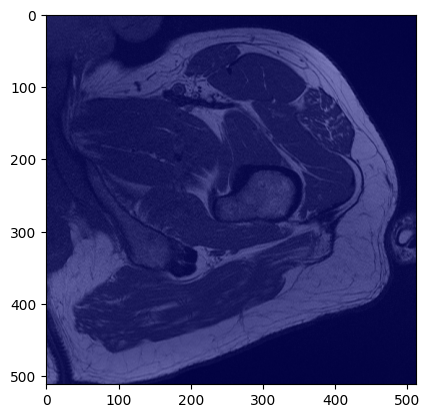

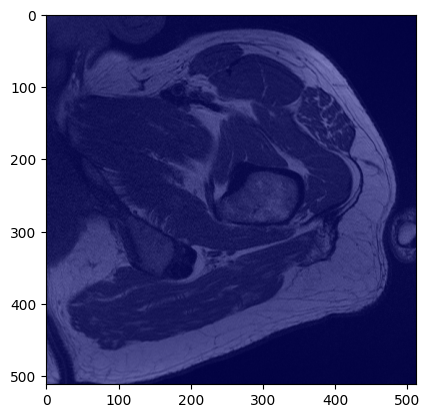

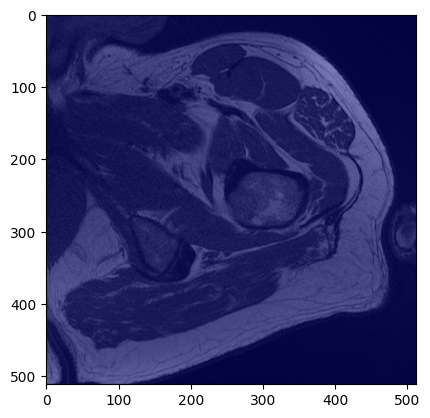

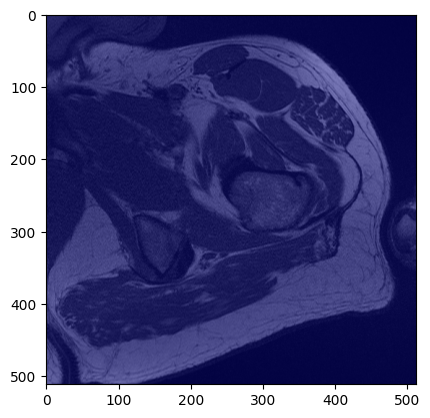

In [16]:
# Get a list of all DICOM files in the directory
image_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
# sort the image_files by their name
image_files.sort(reverse=True)
# Now you can load the DICOM images
images = {pydicom.dcmread(f).SOPInstanceUID: pydicom.dcmread(f) for f in image_files}


# Create an empty binary mask for each image
masks = {uid: np.zeros_like(img.pixel_array) for uid, img in images.items()}
# Get the ROI contour sequence
roi_contour_sequence = rtstruct.ROIContourSequence


# For each ROI
for roi in roi_contour_sequence:
    # Get the contour sequence
    contour_sequence = roi.ContourSequence

    # For each contour
    for contour in contour_sequence:
        # Get the contour data
        contour_data = contour.ContourData
        # Get the SOPInstanceUID of the referenced image
        referenced_sop_instance_uid = contour.ContourImageSequence[0].ReferencedSOPInstanceUID

        # Get the corresponding image
        img = images[referenced_sop_instance_uid]
        # Convert the contour points to pixel coordinates
        contour_points_image = convert_to_pixel_coordinates(contour_data, get_image_position(img), get_pixel_spacing(img))

        # Set the mask values at the contour points to 1
        masks[referenced_sop_instance_uid][contour_points_image[:, 1], contour_points_image[:, 0]] = 1


# Plot an image with the mask overlayed
for i in range(len(images)):
    uid = list(images.keys())[i]  # get the SOPInstanceUID of the first image
    plt.imshow(images[uid].pixel_array, cmap='gray')
    plt.imshow(masks[uid], cmap='jet', alpha=0.5)  # overlay the mask with transparency
    plt.show()



<br><br>
---
<br><br>

In [11]:
# testing rt-utils
%pip install rt_utils

  Using cached opencv_python-4.7.0.72-cp37-abi3-macosx_10_16_x86_64.whl (53.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [13]:
from rt_utils import RTStructBuilder

In [ ]:
# Load existing RT Struct. Requires the series path and existing RT Struct path
rtstruct = RTStructBuilder.create_from(
  dicom_series_path=dicom_dir, 
  rt_struct_path=rtstruct
)

# View all of the ROI names from within the image
print(rtstruct.get_roi_names())

# Loading the 3D Mask from within the RT Struct
mask_3d = rtstruct.get_roi_mask_by_name("ROI NAME")

# Display one slice of the region
first_mask_slice = mask_3d[:, :, 0]
plt.imshow(first_mask_slice)
plt.show()